In [1]:
import wandb
wandb.login(key='fac5cd7f576f5d6d2591b0e77385c09a7922b210')
wandb.init(
    # set the wandb project where this run will be logged
    project="SMAI_ASSIGNMENT3_Part2",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.04,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/Users/swayam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: swayamagrawal1004. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command l

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def sigmoid(x):
    clipped_x = np.clip(x, -50, 50)  # Adjust the range as needed
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def sgd_optimizer(parameters, gradients, learning_rate, batch_size):
    for param, grad in zip(parameters, gradients):
        param -= learning_rate * grad

def batch_gradient_descent(parameters, gradients, learning_rate, batch_size):
    for param, grad in zip(parameters, gradients):
        param -= (learning_rate / batch_size) * grad

def mini_batch_gradient_descent(parameters, gradients, learning_rate, batch_size):
    for param, grad in zip(parameters, gradients):
        param -= learning_rate * grad

class MLPClassifier:
    def __init__(self, input_size, hidden_layers, output_size, learning_rate=0.01, activation='sigmoid', optimizer='sgd'):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        if activation == 'sigmoid':
            self.activation_function = sigmoid
        elif activation == 'tanh':
            self.activation_function = tanh
        elif activation == 'relu':
            self.activation_function = relu
        
        if optimizer == 'sgd':
            self.optimizer = sgd_optimizer
        elif optimizer == 'batch':
            self.optimizer = batch_gradient_descent
        elif optimizer == 'mini-batch':
            self.optimizer = mini_batch_gradient_descent
        
        self.weights, self.biases = self.initialize_weights_and_biases()
    
    def initialize_weights_and_biases(self):
        layer_sizes = [self.input_size] + self.hidden_layers + [self.output_size]
        weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)]
        biases = [np.zeros(layer_size) for layer_size in layer_sizes[1:]]
        return weights, biases

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max to prevent overflow
        return exp_x / exp_x.sum(axis=1, keepdims=True)
    
    def forward_propagation(self, x):
        activations = [x]
        weighted_inputs = []
        
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            # print(" ho: " + str(z.shape))
            weighted_inputs.append(z)
            a = self.activation_function(z)
            activations.append(a)

        activations[-1] = self.softmax(activations[-1])
        # print("Activations shape: " + str(len(activations)))
        # print("Weighted inputs shape " + str(len(weighted_inputs)))
        return activations, weighted_inputs
    
    def backward_propagation(self, x, y, activations, weighted_inputs):
        m = x.shape[0]
        gradients = [np.zeros_like(weight) for weight in self.weights]
        bias_gradients = [np.zeros_like(bias) for bias in self.biases]

        delta = None
        if self.activation_function == sigmoid:
            delta = (activations[-1] - y) * activations[-1] * (1 - activations[-1])
        elif self.activation_function == tanh:
            delta = (activations[-1] - y) * (1 - np.tanh(weighted_inputs[-1]) ** 2)
        elif self.activation_function == relu:
            delta = (activations[-1] - y) * (activations[-1] > 0).astype(float)

        for i in range(len(self.weights) - 1, -1, -1):
            if self.activation_function == sigmoid:
                activation_derivative = activations[i] * (1 - activations[i])
            elif self.activation_function == tanh:
                if(i > 0):
                    activation_derivative = 1 - np.tanh(weighted_inputs[i-1]) ** 2
            elif self.activation_function == relu:
                activation_derivative = (activations[i] > 0).astype(float)
            
            gradients[i] = np.dot(activations[i].T, delta) / m
            bias_gradients[i] = np.sum(delta, axis=0) / m

            if(i == 0):
                continue
            delta = np.dot(delta, self.weights[i].T) * activation_derivative
        
        self.biases = [bias - self.learning_rate * bias_gradient for bias, bias_gradient in zip(self.biases, bias_gradients)]
        return gradients
    
    def train(self, x_train, y_train, epochs, batch_size=None):
        train_losses = []
        for epoch in range(epochs):  
            self.n_samples = x_train.shape[0]
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            X_batches = np.array_split(x_train[shuffle],self.n_samples/batch_size)
            Y_batches = np.array_split(y_train[shuffle],self.n_samples/batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                activations, weighted_inputs = self.forward_propagation(batch_x) 
                train_loss += -np.mean(np.log(activations[-1] + 1e-10) * batch_y)
                gradients = self.backward_propagation(batch_x, batch_y, activations, weighted_inputs)
                self.optimizer(self.weights, gradients, self.learning_rate, batch_size)

            train_loss = (train_loss/len(X_batches))
            train_losses.append(train_loss)
        self.train_lossarr = train_losses   
    
    def predict(self, x):
        activations, _ = self.forward_propagation(x)
        predictions = np.argmax(activations[-1], axis=1)
        return predictions

    def calc_loss(self, x, y):
        activations, _ = self.forward_propagation(x)
        loss = -np.mean(np.log(activations[-1] + 1e-10) * y)
        return loss

In [14]:
wine_data = pd.read_csv("WineQT.csv")
y = wine_data.quality
X = wine_data.drop('quality', axis = 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_val = std_scaler.transform(X_val)
X_test = std_scaler.transform(X_test)

input_size = X_train.shape[1]
output_size = 6  
y_train_one_hot = np.eye(output_size)[y_train-3]
y_val_one_hot = np.eye(output_size)[y_val-3]

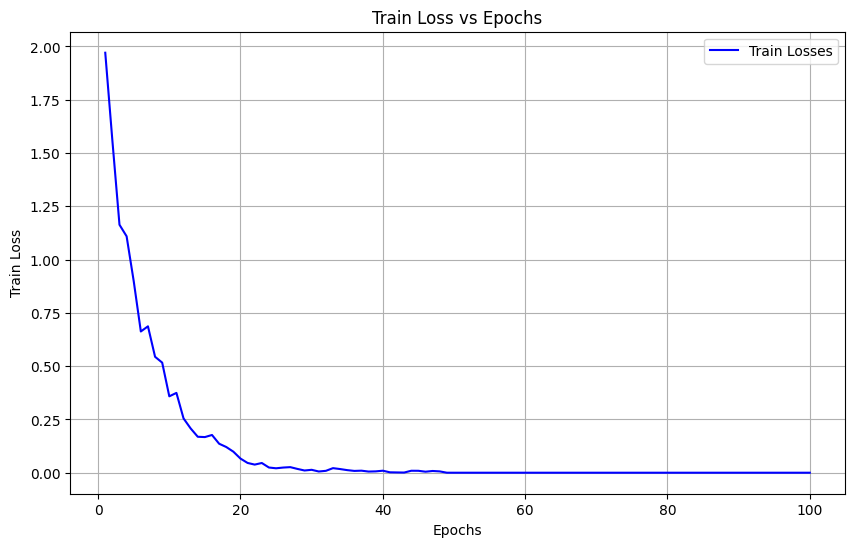

In [15]:
mlp = MLPClassifier(input_size, [128, 128], output_size, 0.01, 'relu', 'mini-batch')
mlp.train(X_train, y_train_one_hot, 100, batch_size=8)
train_arr = mlp.train_lossarr
epochs = list(range(1, 101))

plt.figure(figsize=(10, 6)) 
plt.plot(epochs, train_arr, label='Train Losses', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [5]:
learning_rates = [0.01, 0.03, 0.1]  # Define a range of learning rates
epochs_values = [50, 100, 200]  # Define a range of epochs
hidden_layers_values = [[12, 12], [8, 6], [6, 6]]  # Define different hidden layer configurations
activation_functions = ['sigmoid', 'relu', 'tanh']
optimizers = ['sgd', 'batch', 'mini-batch']

best_params = {}
best_val_accuracy = 0.0

results = []

for lr in learning_rates:
    for epochs_val in epochs_values:
        for hidden_layers_val in hidden_layers_values:
            for activation_func in activation_functions:
                for optimizer_type in optimizers:
                    mlp = MLPClassifier(input_size, hidden_layers_val, output_size, lr, activation_func, optimizer_type)

                    mlp.train(X_train, y_train_one_hot, epochs_val, batch_size=8)
                    
                    train_predictions = mlp.predict(X_train)
                    train_loss = mlp.train_lossarr[-1]
                    train_accuracy = accuracy_score(y_train - 3, train_predictions)

                    val_predictions = mlp.predict(X_val)
                    val_loss = mlp.calc_loss(X_val, y_val_one_hot)
                    val_accuracy = accuracy_score(y_val - 3, val_predictions)

                    f1_sc = f1_score(y_val - 3, val_predictions, average='weighted', zero_division=True)
                    precision = precision_score(y_val - 3, val_predictions, average='weighted', zero_division=True)
                    recall = recall_score(y_val - 3, val_predictions, average='weighted', zero_division=True)

                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_params = {
                            'Learning Rate': lr,
                            'Epochs': epochs_val,
                            'Hidden Layers': hidden_layers_val,
                            'Activation Function': activation_func,
                            'Optimizer': optimizer_type
                        }

                    wandb.log({
                        'Learning Rate': lr,
                        'Epochs': epochs_val,
                        'Hidden Layers': hidden_layers_val,
                        'Activation Function': activation_func,
                        'Optimizer': optimizer_type,
                        'Validation Accuracy': val_accuracy,
                        'Validation Loss': val_loss,
                        'Training Accuracy': train_accuracy,
                        'Training Loss': train_loss,
                        'F1 Score': f1_sc,
                        'Precision': precision,
                        'Recall': recall
                    })

                    results.append({
                        'Learning Rate': lr,
                        'Epochs': epochs_val,
                        'Hidden Layers': hidden_layers_val,
                        'Activation Function': activation_func,
                        'Optimizer': optimizer_type,
                        'Validation Accuracy': val_accuracy,
                        'F1 Score': f1_sc,
                        'Precision': precision,
                        'Recall': recall
                    })

print("Best Model Parameters:")
print(best_params)
print("Best Validation Accuracy:", best_val_accuracy)
wandb.log(best_params)
wandb.log({'Best Validation Accuracy': best_val_accuracy})

results_df = pd.DataFrame(results)
print(results_df)
wandb.log({"Results Table": wandb.Table(dataframe=results_df)})

Best Model Parameters:
{'Learning Rate': 0.03, 'Epochs': 100, 'Hidden Layers': [6, 6], 'Activation Function': 'relu', 'Optimizer': 'mini-batch'}
Best Validation Accuracy: 0.695906432748538
     Learning Rate  Epochs Hidden Layers Activation Function   Optimizer  \
0             0.01      50      [12, 12]             sigmoid         sgd   
1             0.01      50      [12, 12]             sigmoid       batch   
2             0.01      50      [12, 12]             sigmoid  mini-batch   
3             0.01      50      [12, 12]                relu         sgd   
4             0.01      50      [12, 12]                relu       batch   
..             ...     ...           ...                 ...         ...   
238           0.10     200        [6, 6]                relu       batch   
239           0.10     200        [6, 6]                relu  mini-batch   
240           0.10     200        [6, 6]                tanh         sgd   
241           0.10     200        [6, 6]           

## Evaluation for Test Data on both models: Multi Layer Perceptron and Multinomial Regression

In [16]:
lr = best_params['Learning Rate']
activation_func = best_params['Activation Function']
hidden_layers_val = best_params['Hidden Layers']
output_size = 6
optimizer_type = best_params['Optimizer']
input_size = X_test.shape[1]
epochs_val = best_params['Epochs']

mlp = MLPClassifier(input_size, hidden_layers_val, output_size, lr, activation_func, optimizer_type)
mlp.train(X_train, y_train_one_hot, epochs_val, batch_size=20)
test_predictions = mlp.predict(X_test)
test_accuracy = accuracy_score(y_test - 3, test_predictions)
mlpAccuracy = test_accuracy

In [22]:
class MultinomialLogisticRegression:
    def __init__(self, num_classes, learning_rate=0.01, num_epochs=1000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        num_classes = np.max(y) + 1 
        if num_classes != self.num_classes:
            raise ValueError("Number of unique classes does not match num_classes parameter.")
        
        one_hot = np.zeros((y.shape[0], num_classes))
        for i in range(len(y)):

            if y[i] < 0 or y[i] >= num_classes:
                raise ValueError(f"Invalid class label: {y[i]}")
            one_hot[i, y[i]] = 1
        return one_hot

    def fit(self, X, y):
        self.num_features = X.shape[1]

        self.weights = np.random.random((self.num_features, self.num_classes))
        self.bias = np.random.random(self.num_classes)
        
        y_encoded = self.one_hot_encode(y)
        losses = []
        accuracies = []

        for epoch in range(self.num_epochs):
            Z = X@self.weights + self.bias
            A = self.softmax(Z)

            dW = (1/X.shape[0]) * np.dot(X.T, (A - y_encoded))
            db = (1/X.shape[0]) * np.sum(A - y_encoded, axis=0)

            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * db

            loss = self.cross_entropy_loss(y_encoded, A)
            losses.append(loss)
            y_pred = np.argmax(A, axis=1)
            accuracy = np.mean(y == y_pred)
            accuracies.append(accuracy)
        return losses, accuracies
    
    def cross_entropy_loss(self, y, y_pred):
        return -np.mean(y * np.log(y_pred + 1e-15))

    def predict(self, X):
        Z = X@self.weights + self.bias
        A = self.softmax(Z)
        return np.argmax(A, axis=1)
    
    def visualize_decision_boundary(self, X, y):
        X_pca = X
        # print(X_pca, y)
        losses, accuracies = self.fit(X_pca, y)

        x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
        y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))

        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('Decision Boundaries')
        plt.show()

test_model = MultinomialLogisticRegression(num_classes=6, learning_rate=lr, num_epochs=epochs_val)
test_losses, test_accuracies = test_model.fit(X_test, y_test-3)
LogisticAccuracy = test_accuracies[-1]

In [23]:
print("Accuracy on testdata for Multinomial Logistic Regression: " + str(LogisticAccuracy))
print("Accuracy on testdata for Multi Layer Perceptron Classification: " + str(mlpAccuracy))

Accuracy on testdata for Multinomial Logistic Regression: 0.5581395348837209
Accuracy on testdata for Multi Layer Perceptron Classification: 0.6162790697674418


wandb: Network error (ConnectionError), entering retry loop.
